In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
sys.path.append('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code/Experiment/Evaluation')
from Evaluation import *
import jieba
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import logging
from gensim.test.utils import get_tmpfile
from sklearn.manifold import SpectralEmbedding, Isomap, MDS, TSNE
from scipy.stats import ks_2samp
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [30]:
evaluator = Evaluation()
evaluator.PortfolioAnalysis(labels=evaluator.factorNameList, n=3, excess_ret='月收益率_Monret', date='datetime64', weights=['月总市值(元)_Monmc'])

def preprocess_MSVARresult(path:str):
    res = (pd.read_csv(path)
               .assign(separation=lambda x: x[['colMeans.states.']].applymap(lambda x: round(x)))
               .assign(index= lambda x: concat_year_and_month(x))
               .pipe(lambda x: x[['separation','index']])
               .set_index('index')
               .rename(columns={'separation':'0'})
               )
    return res

正在使用Resset数据...Resset数据加载完成。时间：0.6705937385559082


遍历每个股票求解因子载荷: 100%|██████████| 4996/4996 [02:48<00:00, 29.60it/s]


## 寻找状态对应的重点事件

In [66]:
# positive 状态
state_positive = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel2_feeling(positive)_20240328_cutted.csv')
evaluator.addResult(state_positive)
state_positive = evaluator.PAresult['separation']

# neutral 状态
state_neutral = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel2_feeling(neutral)_20240328_cutted.csv')
evaluator.addResult(state_neutral)
state_neutral = evaluator.PAresult['separation']

# negative 状态
state_negative = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel2_feeling(negative)_20240328_cutted.csv')
evaluator.addResult(state_negative)
state_negative = evaluator.PAresult['separation']

# all 状态
state_all = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel2_feeling(all)_20240328_cutted.csv')
evaluator.addResult(state_all)
state_all = evaluator.PAresult['separation']

states = pd.concat(
    {
        'positive':state_positive,
        'neutral' :state_neutral,
        'negative':state_negative,
        'all'     :state_all,
    },
    axis=1
)

states = (
    states.dropna()
    .reset_index()
    .assign(Year=lambda x: x[['datetime64']].applymap(lambda y: y.year))
    .assign(Month=lambda x: x[['datetime64']].applymap(lambda y: y.month))
)
display(states.head())
display(states.tail())

,datetime64,positive,neutral,negative,all,Year,Month
0,2005-05-31,2.0,1.0,2.0,2.0,2005,5
1,2005-06-30,2.0,1.0,2.0,2.0,2005,6
2,2005-07-31,2.0,1.0,2.0,2.0,2005,7
3,2005-08-31,2.0,1.0,2.0,2.0,2005,8
4,2005-09-30,2.0,1.0,2.0,2.0,2005,9


,datetime64,positive,neutral,negative,all,Year,Month
212,2023-01-31,2.0,1.0,2.0,2.0,2023,1
213,2023-02-28,2.0,1.0,2.0,2.0,2023,2
214,2023-03-31,2.0,1.0,2.0,2.0,2023,3
215,2023-04-30,2.0,1.0,2.0,2.0,2023,4
216,2023-05-31,2.0,1.0,2.0,2.0,2023,5


/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_70631/506800983.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(41*10+i+1)


Text(0.5, 0, '事件')

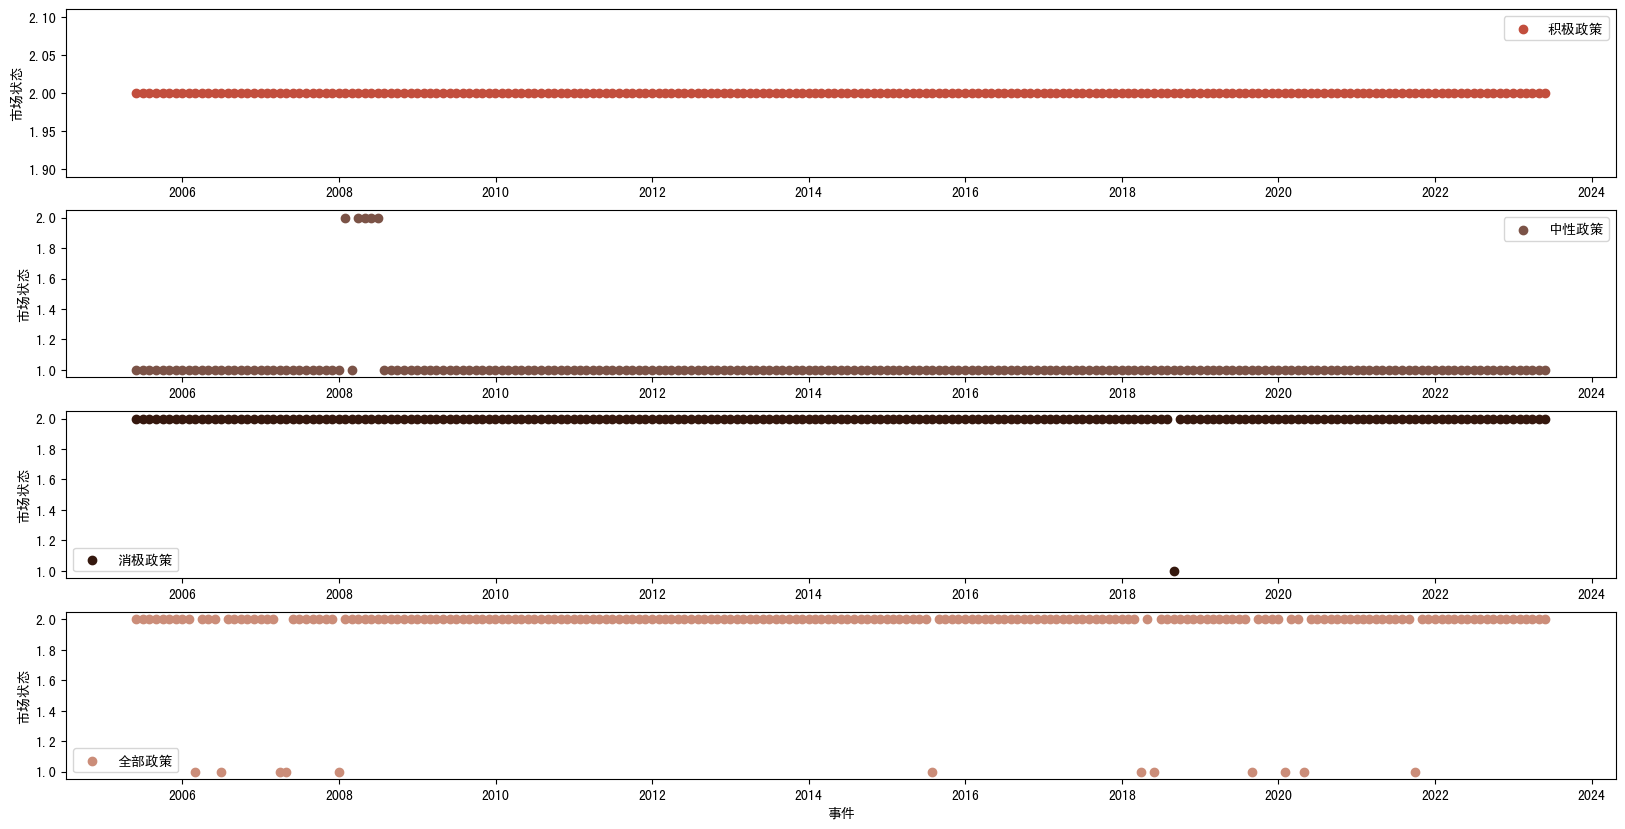

In [67]:
colors={
    'positive':'#c24e3d',
    'neutral':'#7b5347',
    'negative':'#35180e',
    'all':'#cb8d79'
}

labels={
    'positive':'积极政策',
    'neutral':'中性政策',
    'negative':'消极政策',
    'all':'全部政策',
}

fig, ax = plt.subplots(5,1, figsize=(20,10), sharex=True)

for i,value in enumerate(['positive','neutral','negative','all']):
    plt.subplot(41*10+i+1)
    plt.scatter(states['datetime64'], states[value], color=colors[value],label=labels[value])
    plt.legend()
    plt.ylabel('市场状态')
plt.xlabel('事件')

In [35]:
def tokenize_and_del_stopword(stopword_set, text: pd.Series):
    raw_texts = text.to_list()
    res = []
    for raw_text in tqdm(raw_texts):
        tokenized_text = jieba.lcut_for_search(raw_text)
        temp = []
        for word in tokenized_text:
            if not word in stopword_set:
                temp.append(word)
        res.append(temp)
    return res

stopwords = []
with open("/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/baidu_stopwords.txt", "r") as f:
    for line in f.readlines():
        line = line.strip('\n')  # 去掉列表中每一个元素的换行符
        stopwords.append(line)
stopwords = set(stopwords)

Industry_policy = (
    pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/行业政策/ED_IndustryPolicy.csv')
    .pipe(lambda x: pd.merge(pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/RESSET_INDPOLICY_1.csv'), x, left_on='观测ID()_ID', right_on='ID'))
    .assign(InfoPublDateNP=lambda x: x[['InfoPublDate']].applymap(lambda x: np.datetime64(x)))
    .assign(TokenContent=lambda x: tokenize_and_del_stopword(stopwords, x['Content']))
    )

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(Industry_policy['TokenContent'])]
# model = Doc2Vec(documents, vector_size=10, window=4, min_count=1, workers=4)
fname = get_tmpfile("/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model")
# model.save(fname)
model = Doc2Vec.load(fname)  # you can continue training with the loaded model!

# 计算每一个doc的向量
temp_doc = []
for doc in tqdm(Industry_policy['TokenContent'], desc='计算doc对应的向量'):
    temp_doc.append(model.infer_vector(doc))

Industry_policy = (
    Industry_policy
    .assign(DocVec = temp_doc)
    .assign(InfoPublYear = lambda x: x[['InfoPublDateNP']].applymap(lambda x: x.year))
    .assign(InfoPublMon = lambda x: x[['InfoPublDateNP']].applymap(lambda x: x.month))
    .assign(DocVec = temp_doc)
    )
Industry_policy.head(1)

100%|██████████| 22497/22497 [00:39<00:00, 567.73it/s]
2024-03-28 13:51:40,671 : INFO : loading Doc2Vec object from /Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model
2024-03-28 13:51:40,698 : INFO : loading dv recursively from /Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model.dv.* with mmap=None
2024-03-28 13:51:40,699 : INFO : loading wv recursively from /Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model.wv.* with mmap=None
2024-03-28 13:51:40,699 : INFO : setting ignored attribute cum_table to None
2024-03-28 13:51:41,112 : INFO : Doc2Vec lifecycle event {'fname': '/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model', 'datetime': '2024-03-28T13:51:41.112701', 'gensim': '4.3.0', 'python': '3.10.12 (main, Jul  5 2023, 15:02:25) [Clang 14.0.6 ]', 'platform': 'macOS-14.2.1-arm64-arm-64bit', 'event': 'loaded'}
计算doc对应的向量: 100%

,观测ID()_ID,事件标志_EventFlg,信息发布日期_InfoPubDt,媒体出处代码()_MediaCd,媒体出处_Media,撰写机构_Writer,作者_Author,信息内容_Content,信息对象代码()_ObjCd,信息地域划分代码()_RegionCd,...,MediaCode,Writer,Author,InfoTitle,Content,InfoPublDateNP,TokenContent,DocVec,InfoPublYear,InfoPublMon
0,670676730611,1,2021-04-02,3,上海证券报,NaN,NaN,NaN,1000,142.0,...,3,NaN,NaN,权益变动信息 披露知多少,小费阿姨：小钟老师，近期我关注的上市公司发布了临时公告，是关于大股东持有公司权益变动...,2021-04-02,"[小费, 阿姨, 小钟, 老师, 近期, 关注, 上市, 公司, 上市公司, 发布, 临时,...","[1.8061559, -0.9841632, -0.9168915, 0.26965207...",2021,4


In [36]:
print(Industry_policy.columns)
# Industry_policy.loc[(Industry_policy['InfoPublYear']==2008) & (Industry_policy['InfoPublMon']==12)]

Index(['观测ID()_ID', '事件标志_EventFlg', '信息发布日期_InfoPubDt', '媒体出处代码()_MediaCd',
       '媒体出处_Media', '撰写机构_Writer', '作者_Author', '信息内容_Content',
       '信息对象代码()_ObjCd', '信息地域划分代码()_RegionCd', '涉及机构编码_InvInsCd',
       '涉及机构名称_InvInsNm', '信息级别_InfoLevel', '省市编码_ProvNum', '省市名称_Prov',
       '行业编码_IndNum', '行业板块_IndPla', '行业代码_IndCd', '行业名称_IndNm', '记录时间_RecDt',
       'Unnamed: 20', 'ID', 'InfoPublDate', 'Media', 'MediaCode', 'Writer',
       'Author', 'InfoTitle', 'Content', 'InfoPublDateNP', 'TokenContent',
       'DocVec', 'InfoPublYear', 'InfoPublMon'],
      dtype='object')


In [37]:
policy_and_states = pd.merge(states, Industry_policy, left_on=['Year','Month'], right_on=['InfoPublYear','InfoPublMon'])
print(policy_and_states.columns,end='\n')
print(len(policy_and_states))

Index(['datetime64', 'positive', 'neutral', 'negative', 'all', 'Year', 'Month',
       '观测ID()_ID', '事件标志_EventFlg', '信息发布日期_InfoPubDt', '媒体出处代码()_MediaCd',
       '媒体出处_Media', '撰写机构_Writer', '作者_Author', '信息内容_Content',
       '信息对象代码()_ObjCd', '信息地域划分代码()_RegionCd', '涉及机构编码_InvInsCd',
       '涉及机构名称_InvInsNm', '信息级别_InfoLevel', '省市编码_ProvNum', '省市名称_Prov',
       '行业编码_IndNum', '行业板块_IndPla', '行业代码_IndCd', '行业名称_IndNm', '记录时间_RecDt',
       'Unnamed: 20', 'ID', 'InfoPublDate', 'Media', 'MediaCode', 'Writer',
       'Author', 'InfoTitle', 'Content', 'InfoPublDateNP', 'TokenContent',
       'DocVec', 'InfoPublYear', 'InfoPublMon'],
      dtype='object')
19830


In [38]:
print(policy_and_states[['datetime64']].sort_values(by='datetime64').iloc[0])
print(policy_and_states[['datetime64']].sort_values(by='datetime64').iloc[-1])

datetime64   2005-04-30
Name: 0, dtype: datetime64[ns]
datetime64   2023-05-31
Name: 19829, dtype: datetime64[ns]


### 直观分析行业是否受到影响
使用“信息级别”识别出来的市场状态是否能影响各个行业？
1. 通过不同状态的行业收益率的散点图看出:
    1. 不同状态的收益率方差存在差异
    2. 市场状态转换附近的收益率方差比状态中间的方差更小
        例如，以下行业和信息级别较为明显：
        ```
        ind = 'M'; state='InfoLevel1'
        ind = 'M'; state='InfoLevel4'
        ind = 'N'; state='InfoLevel4'
        ind = 'E'; state='general'
        , and so forth....
        ```
2. 检验信息级别对于全行业是否有影响：
    
   方法：固定信息级别，按照状态1和状态2把各行业的收益率方差分组，使用KS检验方差分布
   
   结果：InfoLevel1和InfoLevel3的政策文本识别出来的市场状态的分布差异明显

3. 检验在市场状态切换时，波动率是否有明显降低
   
   方法：使用日度数据计算各个行业的波动率，观察状态转换前后的波动率的平均值
   
   结果：发现在市场状态转换的时候，波动率明显下降；在转换之前和之后波动率更高。

In [39]:
industry_return = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/行业月收益率_流通市值加权.csv',usecols=[0,1,2])
                   .assign(Date_np = lambda x: x[['日期_Date']].applymap(lambda x: np.datetime64(x)))
                   .assign(Year = lambda x: x[['Date_np']].applymap(lambda x: x.year))
                   .assign(Month = lambda x: x[['Date_np']].applymap(lambda x: x.month))
                  )
industry_return = industry_return.pivot(index=['Year','Month'],columns='证监会行业门类代码_Csrciccd1',values='行业月收益率_流通市值加权_Mrettmv').reset_index()
indret_and_states = pd.merge(industry_return, states, left_on=['Year','Month'], right_on=['Year','Month'])
indret_and_states.head()

,Year,Month,A,B,C,D,E,F,G,H,...,O,P,Q,R,S,datetime64,positive,neutral,negative,all
0,2005,4,-0.0744,0.0072,-0.0448,-0.0106,-0.0383,-0.0189,0.0168,0.0455,...,-0.0702,NaN,NaN,-0.2547,-0.0908,2005-04-30,1.0,1.0,1.0,1.0
1,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,-0.0188,NaN,NaN,0.0376,-0.0265,2005-05-31,2.0,1.0,1.0,2.0
2,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,0.0173,NaN,NaN,0.0172,-0.0175,2005-06-30,2.0,2.0,1.0,2.0
3,2005,7,-0.0902,0.0307,-0.0386,-0.0029,-0.0635,-0.0315,0.0165,-0.0063,...,-0.1237,NaN,NaN,-0.1235,-0.0571,2005-07-31,2.0,2.0,2.0,2.0
4,2005,8,0.1438,0.0597,0.0845,0.0021,0.1179,0.0961,0.0109,0.1436,...,0.1685,NaN,NaN,0.2522,0.1417,2005-08-31,2.0,2.0,2.0,2.0


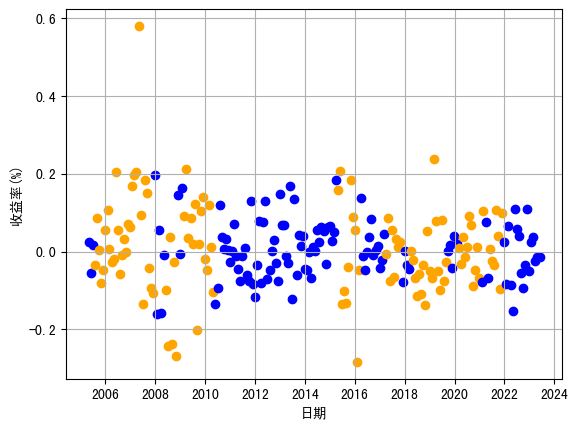

In [40]:
# ind = 'M'; state='positive'
ind = 'N'; state='negative'
# ind = 'N'; state='InfoLevel4'
# ind = 'E'; state='general'
fig, ax = plt.subplots()
colors = ['blue','orange']
for i in range(len(indret_and_states)):
    ax.scatter(indret_and_states['datetime64'][i], indret_and_states[ind][i], 
               color=colors[int(indret_and_states[state][i]-1)], 
               alpha=1)
# ax.set_title("不同市场状态下收益率散点图\n（行业={}, 信息级别={}）".format(ind, state[-1]))
ax.set_xlabel("日期")
ax.set_ylabel('收益率(%)')
ax.grid(True)
plt.savefig('/Users/yanyan/Downloads/图片/不同市场状态下收益率散点图_ind{}_{}'.format(ind,state),dpi=350)
plt.show()

In [41]:
# state_1 = []; state_2=[]
# # for state in ['InfoLevel1', 'InfoLevel2', 'InfoLevel3', 'InfoLevel4']:
# for state in ['general', 'InfoLevel1']:
#     for ind in list("BMLQOE"):
#         state_1.append(indret_and_states.groupby(state)[ind].std().values[0])
#         state_2.append(indret_and_states.groupby(state)[ind].std().values[1])
# print(ks_2samp(state_1, state_2))
# print("MEAN of state 1={}, MEAN of state 2={}".format(np.round(np.mean(state_1),4), np.round(np.mean(state_2),4)))
# print("STD of state 1={}, STD of state 2={},".format(np.round(np.std(state_1),4), np.round(np.std(state_2),4)))
# # print(np.mean(state_1), np.mean(state_2))
# # print(np.std(state_1), np.std(state_2))

In [42]:
for state in ['positive','neutral','negative','all']:
    state_1 = []; state_2=[]
    for ind in industry_return.columns[2:]:
        state_1.append(indret_and_states.groupby(state)[ind].std().values[0])
        state_2.append(indret_and_states.groupby(state)[ind].std().values[1])
    print("state: {}".format(state))
    print(ks_2samp(state_1, state_2))
    print("MEAN of state 1={}%,\t MEAN of state 2={}%".format(np.round(np.mean(state_1),4)*100, np.round(np.mean(state_2),4)*100))
    print("STD  of state 1={}%,\t STD  of state 2={}%,".format(np.round(np.std(state_1),4)*100, np.round(np.std(state_2),4)*100))
    print()

state: positive
KstestResult(statistic=0.10526315789473684, pvalue=0.9999851666689215, statistic_location=0.08637872603378863, statistic_sign=1)
MEAN of state 1=10.290000000000001%,	 MEAN of state 2=10.290000000000001%
STD  of state 1=2.1399999999999997%,	 STD  of state 2=1.95%,

state: neutral
KstestResult(statistic=0.5789473684210527, pvalue=0.002767187834654101, statistic_location=0.09433530273470231, statistic_sign=1)
MEAN of state 1=9.8%,	 MEAN of state 2=11.03%
STD  of state 1=2.32%,	 STD  of state 2=1.7500000000000002%,

state: negative
KstestResult(statistic=0.7894736842105263, pvalue=4.176797231882591e-06, statistic_location=0.08852992686346493, statistic_sign=1)
MEAN of state 1=8.82%,	 MEAN of state 2=11.68%
STD  of state 1=2.32%,	 STD  of state 2=1.81%,

state: all
KstestResult(statistic=0.5789473684210527, pvalue=0.002767187834654101, statistic_location=0.10089788965480129, statistic_sign=1)
MEAN of state 1=9.74%,	 MEAN of state 2=11.67%
STD  of state 1=1.9900000000000002%,

,Year,Month,A,B,C,D,E,F,G,H,...,J_Var,K_Var,L_Var,M_Var,N_Var,O_Var,P_Var,Q_Var,R_Var,S_Var
0,2005,4,-0.0744,0.0072,-0.0448,-0.0106,-0.0383,-0.0189,0.0168,0.0455,...,0.000438,0.000289,0.000221,NaN,0.000194,0.000712,NaN,NaN,0.001199,0.000485
1,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,0.000201,0.000300,0.000204,NaN,0.000088,0.000353,NaN,NaN,0.000548,0.000168
2,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,0.000559,0.000547,0.000566,NaN,0.000477,0.000528,NaN,NaN,0.000989,0.000562
3,2005,7,-0.0902,0.0307,-0.0386,-0.0029,-0.0635,-0.0315,0.0165,-0.0063,...,0.000320,0.000469,0.000291,NaN,0.000294,0.000855,NaN,NaN,0.001450,0.000391
4,2005,8,0.1438,0.0597,0.0845,0.0021,0.1179,0.0961,0.0109,0.1436,...,0.000253,0.000265,0.000369,NaN,0.000166,0.000644,NaN,NaN,0.000603,0.000240


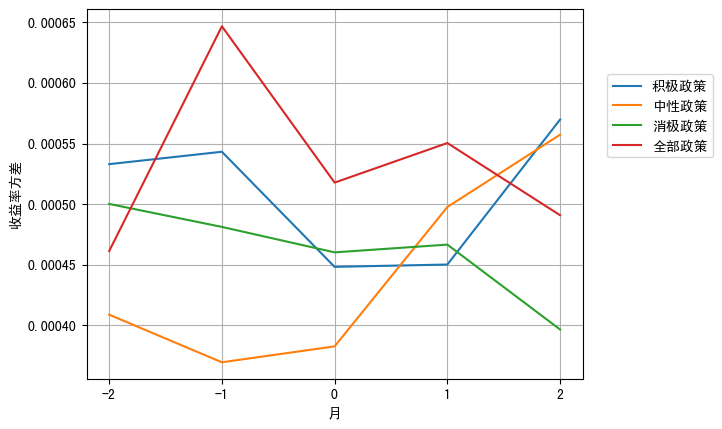

In [43]:
temp = (pd.concat([pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/证监会门类行业日收益率/RESSET_DRET_INDUSTRY_1_1.csv'), 
                  pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/证监会门类行业日收益率/RESSET_DRET_INDUSTRY_1_2.csv')],
                  axis=0
                 )
        .assign(datetime64 = lambda x: x[['日期_Date']].applymap(lambda x: np.datetime64(x)))
        .set_index('datetime64')
        .pipe(lambda x: x.groupby('证监会行业门类代码_Csrciccd1')['行业日收益率_流通市值加权_Drettmv'].resample('M').var())
        .reset_index()
        .pivot_table(index='datetime64',columns='证监会行业门类代码_Csrciccd1',values='行业日收益率_流通市值加权_Drettmv')
       )
temp = pd.merge(indret_and_states, temp, left_on='datetime64',right_on='datetime64', suffixes=['','_Var'])
display(temp.head())

var = temp[['datetime64','A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']]

fig, ax = plt.subplots()
n=2
for state in ['positive','neutral','negative','all']:
    diff = temp[[state]].diff()
    before_2=[];before_1=[]; current = []; after_1=[]; after_2=[]
    for i in (diff.loc[diff[state]!=0]).index:
        for ind in ['N']:
            ind = ind + '_Var'
            current.append(temp[ind].iloc[i])
            if i-2 >= 0: before_2.append(temp[ind].iloc[i-2]) 
            if i-1 >= 0: before_1.append(temp[ind].iloc[i-1])
            if i+1 < len(temp): after_1.append(temp[ind].iloc[i+1])
            if i+2 < len(temp): after_2.append(temp[ind].iloc[i+2])
    y = [np.nanmean(before_2),np.nanmean(before_1), np.nanmean(current), np.nanmean(after_1), np.nanmean(after_2)]
    labels={
        'positive':'积极政策',
        'neutral':'中性政策',
        'negative':'消极政策',
        'all':'全部政策'
    }
    colors={
        'positive':'#c24e3d',
        'neutral':'#7b5347',
        'negative':'#35180e',
        'all':'#cb8d79'
    }
    ax.plot([-2,-1,0,1,2],y,label=labels[state],)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
ax.set_ylabel('收益率方差')
ax.set_xlabel('月')
# ax.set_title('状态转换附近5月的收益率方差')
ax.grid(True)
plt.savefig('/Users/yanyan/Downloads/图片/状态转换附近5月的收益率方差', dpi=350)
plt.show()

<Axes: xlabel='datetime64'>

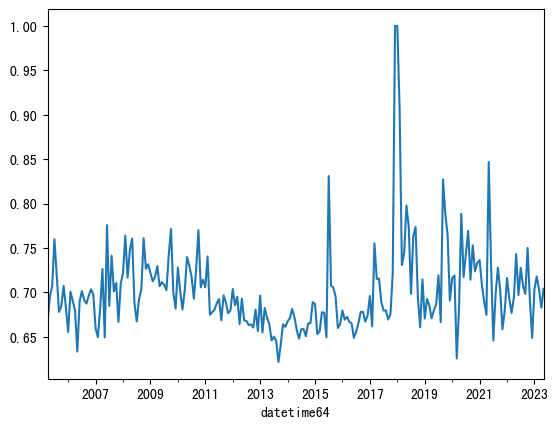

In [44]:
def get_concentration(arr):
    std_arr = []
    for x in arr:
        std_arr.append(x / np.linalg.norm(x))
    sum_arr = np.sum(np.array(std_arr), axis=0) / len(std_arr)
    return np.linalg.norm(sum_arr)
(policy_and_states.groupby('datetime64')['DocVec'].apply(lambda x: get_concentration(x.values))).plot()

,Year,Month,A,B,C,D,E,F,G,H,...,P,Q,R,S,datetime64,positive,neutral,negative,all,concentration
0,2005,4,-0.0744,0.0072,-0.0448,-0.0106,-0.0383,-0.0189,0.0168,0.0455,...,NaN,NaN,-0.2547,-0.0908,2005-04-30,1.0,1.0,1.0,1.0,0.728953
1,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,NaN,NaN,0.0376,-0.0265,2005-05-31,2.0,1.0,1.0,2.0,0.756063
2,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,NaN,NaN,0.0172,-0.0175,2005-06-30,2.0,2.0,1.0,2.0,0.770109
3,2005,7,-0.0902,0.0307,-0.0386,-0.0029,-0.0635,-0.0315,0.0165,-0.0063,...,NaN,NaN,-0.1235,-0.0571,2005-07-31,2.0,2.0,2.0,2.0,0.793373
4,2005,8,0.1438,0.0597,0.0845,0.0021,0.1179,0.0961,0.0109,0.1436,...,NaN,NaN,0.2522,0.1417,2005-08-31,2.0,2.0,2.0,2.0,0.760910


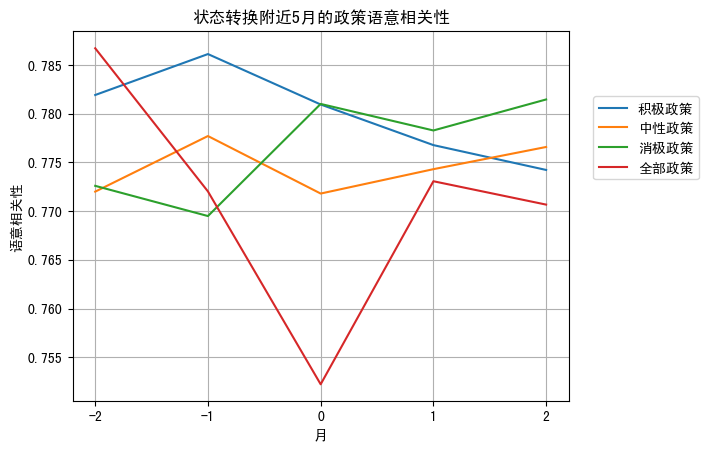

In [45]:
labels={
    'positive':'积极政策',
    'neutral':'中性政策',
    'negative':'消极政策',
    'all':'全部政策'
}
colors={
    'positive':'#c24e3d',
    'neutral':'#7b5347',
    'negative':'#35180e',
    'all':'#cb8d79'
}
def recursive_corr(arr):
    corr_list = []
    for i in range(len(arr)):
        for j in range(i,len(arr)):
            corr_list.append(np.corrcoef(arr[i],arr[j]))
    return np.mean(corr_list)

temp = (pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].apply(lambda x: recursive_corr(x.values)))
        .rename(columns={'DocVec':'concentration'})
       )

temp = pd.merge(indret_and_states, temp, left_on='datetime64',right_on='datetime64')

concentration = temp
display(temp.head())
fig, ax = plt.subplots()
for state in ['positive','neutral','negative','all']:
    diff = temp[[state]].diff()
    before_2=[];before_1=[]; current = []; after_1=[]; after_2=[]
    for i in (diff.loc[diff[state]!=0]).index:
            current.append(temp['concentration'].iloc[i])
            if i-2 >= 0: before_2.append(temp['concentration'].iloc[i-2]) 
            if i-1 >= 0: before_1.append(temp['concentration'].iloc[i-1])
            if i+1 < len(temp): after_1.append(temp['concentration'].iloc[i+1])
            if i+2 < len(temp): after_2.append(temp['concentration'].iloc[i+2])
    y = [np.nanmean(before_2),np.nanmean(before_1), np.nanmean(current), np.nanmean(after_1), np.nanmean(after_2)]
    ax.plot([-2,-1,0,1,2],y,label=labels[state],)
    
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
ax.set_title('状态转换附近5月的政策语意相关性')
ax.set_xlabel('月')
ax.set_ylabel('语意相关性')
ax.grid(True)
plt.show()

,Year,Month,A,B,C,D,E,F,G,H,...,P,Q,R,S,datetime64,positive,neutral,negative,all,concentration
0,2005,4,-0.0744,0.0072,-0.0448,-0.0106,-0.0383,-0.0189,0.0168,0.0455,...,NaN,NaN,-0.2547,-0.0908,2005-04-30,1.0,1.0,1.0,1.0,131
1,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,NaN,NaN,0.0376,-0.0265,2005-05-31,2.0,1.0,1.0,2.0,106
2,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,NaN,NaN,0.0172,-0.0175,2005-06-30,2.0,2.0,1.0,2.0,75
3,2005,7,-0.0902,0.0307,-0.0386,-0.0029,-0.0635,-0.0315,0.0165,-0.0063,...,NaN,NaN,-0.1235,-0.0571,2005-07-31,2.0,2.0,2.0,2.0,89
4,2005,8,0.1438,0.0597,0.0845,0.0021,0.1179,0.0961,0.0109,0.1436,...,NaN,NaN,0.2522,0.1417,2005-08-31,2.0,2.0,2.0,2.0,100


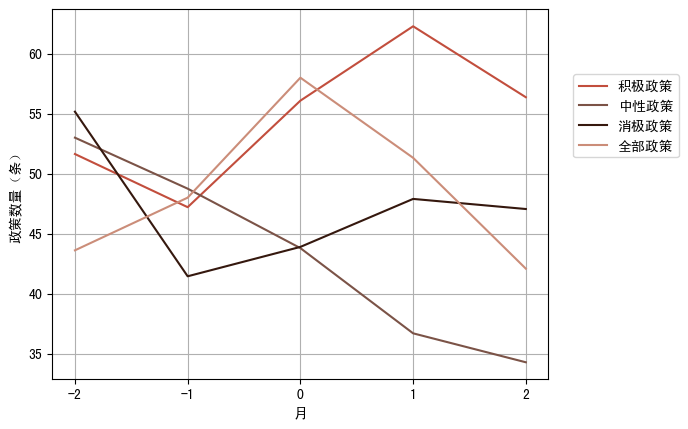

In [46]:
# labels={
#     'general':'全部',
#     'InfoLevel1':'一级政策',
#     'InfoLevel2':'二级政策',
#     'InfoLevel3':'三级政策',
#     'InfoLevel4':'四级政策',
# }
# colors={
#     'general':'#c24e3d',
#     'InfoLevel1':'#7b5347',
#     'InfoLevel2':'#35180e',
#     'InfoLevel3':'#cb8d79',
#     'InfoLevel4':'#fad4ca',
# }

temp = (pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count())
        .rename(columns={'DocVec':'concentration'})
       )

temp = pd.merge(indret_and_states, temp, left_on='datetime64',right_on='datetime64')
display(temp.head())

num = {}

fig, ax = plt.subplots()
for state in ['positive','neutral','negative','all']:
    diff = temp[[state]].diff()
    before_2=[];before_1=[]; current = []; after_1=[]; after_2=[]
    for i in (diff.loc[diff[state]!=0]).index:
            current.append(temp['concentration'].iloc[i])
            if i-2 >= 0: before_2.append(temp['concentration'].iloc[i-2]) 
            if i-1 >= 0: before_1.append(temp['concentration'].iloc[i-1])
            if i+1 < len(temp): after_1.append(temp['concentration'].iloc[i+1])
            if i+2 < len(temp): after_2.append(temp['concentration'].iloc[i+2])
    y = [np.nanmean(before_2),np.nanmean(before_1), np.nanmean(current), np.nanmean(after_1), np.nanmean(after_2)]
#     print(state, '\t', y)
#     if state=='general': print((diff.loc[diff[state]!=0]).index)
#     if state=='InfoLevel1': print((diff.loc[diff[state]!=0]).index)
    ax.plot([-2,-1,0,1,2],y,label=labels[state],color=colors[state])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
# ax.set_title('状态转换附近5月的政策数量')
ax.set_xlabel('月')
ax.set_ylabel('政策数量（条）')
ax.grid(True)
plt.savefig('/Users/yanyan/Downloads/图片/状态转换附近5月的政策数量.png',dpi=250)
plt.show()

#### 检查不同的市场状态下的向量的距离

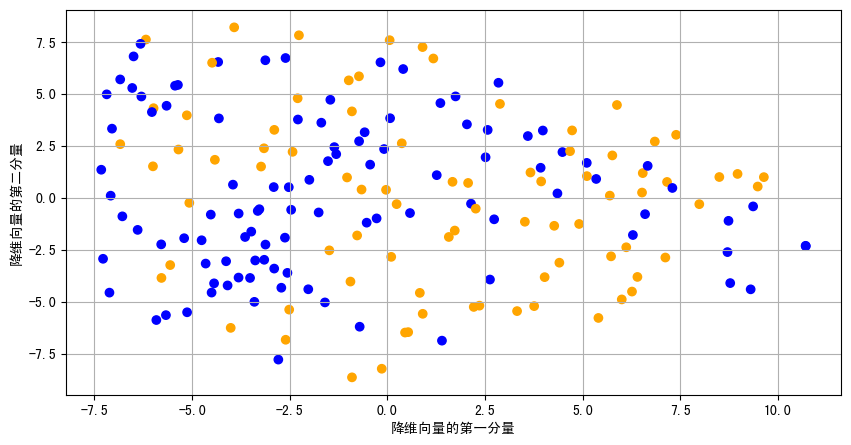

In [47]:
# 降维散点图
# labels={
#     'general':'全部',
#     'InfoLevel1':'一级政策',
#     'InfoLevel2':'二级政策',
#     'InfoLevel3':'三级政策',
#     'InfoLevel4':'四级政策',
# }

from sklearn.manifold import SpectralEmbedding, Isomap, MDS, TSNE

def scatter_dimension_reduced(start, end, state):
    temp = pd.merge(policy_and_states.groupby(['Year','Month'])['DocVec'].mean().reset_index(),
         states,
         left_on=['Year','Month'],
         right_on=['Year','Month']
        )
    temp = temp.loc[(temp['datetime64']>=start) & (temp['datetime64']<=end)]
#     display(temp)
    
    X_embedded = TSNE(n_components=2).fit_transform(np.array([i.tolist() for i in temp['DocVec'].values]))
    temp['TsneVec'] = [X_embedded[i] for i in range(len(X_embedded))]
    x = [i[0] for i in temp['TsneVec'].values]
    y = [i[1] for i in temp['TsneVec'].values]
    colors = temp[state].map({
        1:'blue',
        2:'orange'
    }).tolist()
    fig, ax = plt.subplots(figsize=(10,5))
    plt.scatter(x, y, c=colors)
    ax.set_xlabel('降维向量的第一分量')
    ax.set_ylabel('降维向量的第二分量')
    plt.grid(True)
#     plt.title('降维政策文本向量散点图 \n({})'.format(labels[state]))
    plt.show()

scatter_dimension_reduced(start='2007-12', end='2023-5',state='positive')

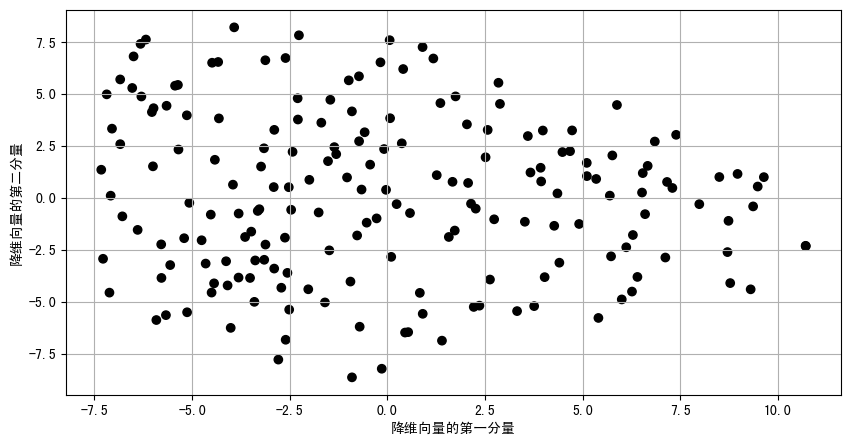

In [48]:
# 降维散点图
from sklearn.manifold import SpectralEmbedding, Isomap, MDS, TSNE

def scatter_dimension_reduced(start, end, state):
    temp = pd.merge(policy_and_states.groupby(['Year','Month'])['DocVec'].mean().reset_index(),
         states,
         left_on=['Year','Month'],
         right_on=['Year','Month']
        )
    temp = temp.loc[(temp['datetime64']>=start) & (temp['datetime64']<=end)]
#     display(temp)
    
    X_embedded = TSNE(n_components=2).fit_transform(np.array([i.tolist() for i in temp['DocVec'].values]))
    temp['TsneVec'] = [X_embedded[i] for i in range(len(X_embedded))]
    x = [i[0] for i in temp['TsneVec'].values]
    y = [i[1] for i in temp['TsneVec'].values]
    colors = temp[state].map({
        1:'#000000',
        2:'#000000'
    }).tolist()
    fig, ax = plt.subplots(figsize=(10,5))
    plt.scatter(x, y, c=colors)
    ax.set_xlabel('降维向量的第一分量')
    ax.set_ylabel('降维向量的第二分量')
#     ax.set_title('2维政策文本向量分布散点图')
    ax.grid(True)
    plt.show()

scatter_dimension_reduced(start='2007-12', end='2023-5',state='positive')

### 回归

1. 检验政策数量是否对收益率波动性有显著影响

2. 检验政策相关性是否对收益率波动性有显著影响

In [49]:
SZZZ = (pd.read_csv('/Users/yanyan/Downloads/RESSET_IDXMONRET_1.csv')
        .assign(datetime64 = lambda x: x[['交易日期_TrdDt']].applymap(lambda x: np.datetime64(x)))
        .pipe(lambda x: x[['datetime64','指数月收益率_IdxMonRet']])
        .pipe(lambda x: pd.merge(left=concentration, right=x, left_on='datetime64',right_on='datetime64'))
       )

display(SZZZ.head())

,Year,Month,A,B,C,D,E,F,G,H,...,Q,R,S,datetime64,positive,neutral,negative,all,concentration,指数月收益率_IdxMonRet
0,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,NaN,0.0376,-0.0265,2005-05-31,2.0,1.0,1.0,2.0,0.756063,-0.0849
1,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,NaN,0.0172,-0.0175,2005-06-30,2.0,2.0,1.0,2.0,0.770109,0.0190
2,2005,8,0.1438,0.0597,0.0845,0.0021,0.1179,0.0961,0.0109,0.1436,...,NaN,0.2522,0.1417,2005-08-31,2.0,2.0,2.0,2.0,0.760910,0.0736
3,2005,9,0.0217,0.0100,0.0175,-0.0155,0.0302,0.0378,-0.0138,0.0461,...,NaN,-0.0949,-0.0382,2005-09-30,2.0,1.0,2.0,1.0,0.737663,-0.0062
4,2005,10,-0.0761,-0.0745,-0.0659,-0.0772,-0.0386,-0.0602,-0.0715,-0.0784,...,NaN,-0.0273,-0.0799,2005-10-31,2.0,1.0,2.0,2.0,0.745124,-0.0543


In [50]:
temp = (pd.merge(var, concentration, left_on='datetime64',right_on='datetime64')
        .pipe(lambda x: pd.merge(x,
                                pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count()).rename(columns={'DocVec':'num'}),
                                    left_on='datetime64',right_on='datetime64'
                                ))
       )
# display(temp.head())
print('检验政策数量是否对收益率波动性有显著影响(无收益率滞后项)')
for ind in ['A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']:
    t = (temp[[ind, 'num']]).copy()
    t.dropna(inplace=True)
    model = sm.OLS(
        t[[ind]],
        sm.add_constant(t[['num']])
    ).fit()
    print("{}:\t P-(num)={}".format(ind[0], model.pvalues['num']),end='')
    if model.pvalues['num']<0.01: print("***")
    elif model.pvalues['num']>=0.01 and model.pvalues['num']<0.05: print("**")
    elif model.pvalues['num']>=0.05 and model.pvalues['num']<0.1: print("*")
    else: print()
    
print('\n\n检验政策相关性是否对收益率波动性有显著影响(无收益率滞后项)')
for ind in ['A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']:
    t = (temp[[ind, 'concentration']]).copy()
    t.dropna(inplace=True)
    model = sm.OLS(
        t[[ind]],
        sm.add_constant(t[['concentration']])
    ).fit()
    print("{}:\t P-(concentration)={}".format(ind[0], model.pvalues['concentration']), end='')
    if model.pvalues['concentration']<0.01: print("***")
    elif model.pvalues['concentration']>=0.01 and model.pvalues['concentration']<0.05: print("**")
    elif model.pvalues['concentration']>=0.05 and model.pvalues['concentration']<0.1: print("*")
    else: print()

检验政策数量是否对收益率波动性有显著影响(无收益率滞后项)
A:	 P-(num)=2.5811008261077946e-05***
B:	 P-(num)=5.596474828782898e-06***
C:	 P-(num)=0.00015803098247121298***
D:	 P-(num)=0.00035124363705943846***
E:	 P-(num)=0.0017528191124124362***
F:	 P-(num)=0.0011426054478175162***
G:	 P-(num)=0.0002232822096145705***
H:	 P-(num)=2.7853182317987893e-06***
I:	 P-(num)=0.0013222922343384266***
J:	 P-(num)=3.501843072611894e-05***
K:	 P-(num)=8.493474621568054e-05***
L:	 P-(num)=5.1640545921659175e-06***
M:	 P-(num)=0.011191897031083519**
N:	 P-(num)=9.859304894161508e-05***
O:	 P-(num)=5.388592664477175e-06***
P:	 P-(num)=0.03224175466141258**
Q:	 P-(num)=0.005187182345345282***
R:	 P-(num)=0.006144070504392302***
S:	 P-(num)=0.0006010273799786662***


检验政策相关性是否对收益率波动性有显著影响(无收益率滞后项)
A:	 P-(concentration)=0.010028887126807726**
B:	 P-(concentration)=0.013770253924956932**
C:	 P-(concentration)=0.028718451312368113**
D:	 P-(concentration)=0.054337949200460534*
E:	 P-(concentration)=0.17639322761604148
F:	 P-(concentr

In [51]:
temp = (pd.merge(var, concentration, left_on='datetime64',right_on='datetime64')
        .pipe(lambda x: pd.merge(x,
                                pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count()).rename(columns={'DocVec':'num'}),
                                    left_on='datetime64',right_on='datetime64'
                                ))
       )
# display(temp.head())
print('检验政策数量是否对收益率波动性有显著影响（有收益率滞后项）')
for ind in ['A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']:
    t = (temp[[ind, 'num']]).copy()
    t.dropna(inplace=True)
    model = sm.OLS(
        t[[ind]][1:],
        pd.concat([sm.add_constant(t[['num']]), t[[ind]].shift(1)],axis=1)[1:]
    ).fit()
    print("{}:\t P-(num)={}".format(ind[0], model.pvalues['num']),end='')
    if model.pvalues['num']<0.01: print("***")
    elif model.pvalues['num']>=0.01 and model.pvalues['num']<0.05: print("**")
    elif model.pvalues['num']>=0.05 and model.pvalues['num']<0.1: print("*")
    else: print()
    
print('\n\n检验政策相关性是否对收益率波动性有显著影响（有收益率滞后项）')
for ind in ['A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']:
    t = (temp[[ind, 'concentration']]).copy()
    t.dropna(inplace=True)
    model = sm.OLS(
        t[[ind]][1:],
        pd.concat([sm.add_constant(t[['concentration']]), t[[ind]].shift(1)],axis=1)[1:]
    ).fit()
    print("{}:\t P-(concentration)={}".format(ind[0], model.pvalues['concentration']), end='')
    if model.pvalues['concentration']<0.01: print("***")
    elif model.pvalues['concentration']>=0.01 and model.pvalues['concentration']<0.05: print("**")
    elif model.pvalues['concentration']>=0.05 and model.pvalues['concentration']<0.1: print("*")
    else: print()

检验政策数量是否对收益率波动性有显著影响（有收益率滞后项）
A:	 P-(num)=0.00493236117050713***
B:	 P-(num)=0.00762362911320372***
C:	 P-(num)=0.010852713310767769**
D:	 P-(num)=0.03310876734476145**
E:	 P-(num)=0.03839428994668706**
F:	 P-(num)=0.0233166884625713**
G:	 P-(num)=0.02146213213437728**
H:	 P-(num)=0.003538182055236654***
I:	 P-(num)=0.024175675506360475**
J:	 P-(num)=0.04165006413073123**
K:	 P-(num)=0.013581957754159494**
L:	 P-(num)=0.00410384767151527***
M:	 P-(num)=0.012266399380790775**
N:	 P-(num)=0.011579772396305189**
O:	 P-(num)=0.0001715732406843704***
P:	 P-(num)=0.25169337985331347
Q:	 P-(num)=0.07872725719572249*
R:	 P-(num)=0.04093276695165982**
S:	 P-(num)=0.0172850663590888**


检验政策相关性是否对收益率波动性有显著影响（有收益率滞后项）
A:	 P-(concentration)=0.0252802082779453**
B:	 P-(concentration)=0.04710911958473023**
C:	 P-(concentration)=0.09464992315469171*
D:	 P-(concentration)=0.11004883617009405
E:	 P-(concentration)=0.2655836624756213
F:	 P-(concentration)=0.06636041190159786*
G:	 P-(concentration)=0.070

检验政策相关性是否对收益率波动性有显著影响


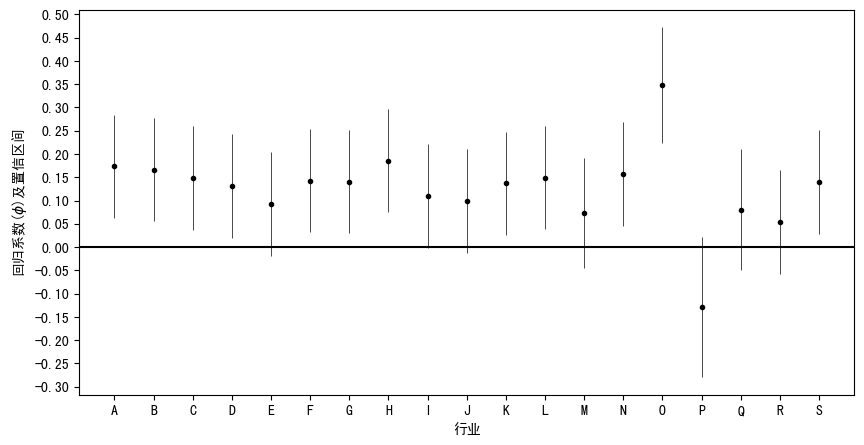

In [52]:
from scipy.stats import zscore

alpha = 0.1

temp = (pd.merge(var, concentration, left_on='datetime64',right_on='datetime64')
        .pipe(lambda x: pd.merge(x,
                                pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count()).rename(columns={'DocVec':'num'}),
                                    left_on='datetime64',right_on='datetime64'
                                ))
       )


print('检验政策相关性是否对收益率波动性有显著影响')
fig, ax = plt.subplots(figsize=(10,5))

for ind in ['A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']:
    t = (temp[[ind, 'concentration']]).copy()
    t.dropna(inplace=True)
    model = sm.OLS(
        zscore(t[[ind]]),
        sm.add_constant(zscore(t[['concentration']]))
    ).fit()
#     print(model.summary())
    y_error = model.conf_int(alpha).loc['concentration',:].values.reshape((2,1))[1][0]\
                - model.params['concentration']
    ax.errorbar(ind[0],
                model.params['concentration'],
                yerr=y_error,
                fmt='o',
                markersize=3.,
                color='black',
                lw=0.5
               )
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
# plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
ax.set_xlabel('行业')
ax.set_ylabel('回归系数($\phi$)及置信区间')
# ax.set_title('收益率波动性对政策相关性回归结果\n '+r'$\alpha={}$'.format(alpha))
ax.axhline(0,color='black')
plt.show()

检验政策数量是否对收益率波动性有显著影响


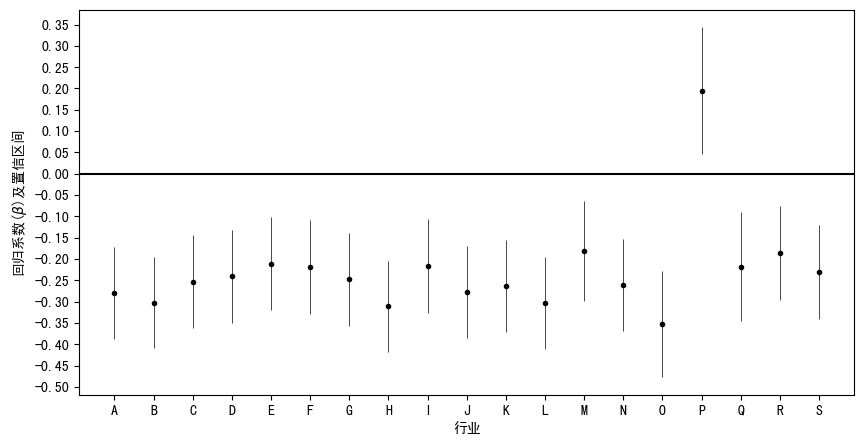

In [53]:
from scipy.stats import zscore

alpha = 0.1

temp = (pd.merge(var, concentration, left_on='datetime64',right_on='datetime64')
        .pipe(lambda x: pd.merge(x,
                                pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count()).rename(columns={'DocVec':'num'}),
                                    left_on='datetime64',right_on='datetime64'
                                ))
       )
# display(temp.head())
print('检验政策数量是否对收益率波动性有显著影响')

fig, ax = plt.subplots(figsize=(10,5))
for ind in ['A_Var',
       'B_Var', 'C_Var', 'D_Var', 'E_Var', 'F_Var', 'G_Var', 'H_Var', 'I_Var',
       'J_Var', 'K_Var', 'L_Var', 'M_Var', 'N_Var', 'O_Var', 'P_Var', 'Q_Var',
       'R_Var', 'S_Var']:
    t = (temp[[ind, 'num']]).copy()
    t.dropna(inplace=True)
    model = sm.OLS(
        zscore(t[[ind]]),
        sm.add_constant(zscore(t[['num']]))
    ).fit()
    y_error = model.conf_int(alpha).loc['num',:].values.reshape((2,1))[1][0]\
                - model.params['num']
    ax.errorbar(ind[0],
                model.params['num'],
                yerr=y_error,
                fmt='o',
                markersize=3.,
                color='black',
                lw=0.5
               )
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
# plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
ax.set_xlabel('行业')
ax.set_ylabel(r'回归系数($\beta$)及置信区间')
# ax.set_title('收益率波动性对政策数量回归结果\n '+r'$\alpha={}$'.format(alpha))
ax.axhline(0,color='black')
plt.show()

# 收益率分解视角

In [58]:
index_assetpricing = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/指数估值指标.csv',usecols=[0,1,2,3])
                      .assign(datetime64=lambda x: x[['交易日_TrdDt']].applymap(lambda x: np.datetime64(x)))
                      .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
                      .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
                      .assign(IndexCode=lambda x: x[['指数代码_IdxCd']].applymap(lambda y: str(y).zfill(6)))
                     )
print(len(index_assetpricing))
print((index_assetpricing['IndexCode']).unique())
# index_assetpricing.head()
index_000001 = index_assetpricing.loc[index_assetpricing['IndexCode']=='000001'][['Year','Month','滚动市盈率_PE_TTM','滚动股息率(%)_DYR_TTM']].groupby(['Year','Month']).mean()
index_000001.reset_index(inplace=True)
# index_000001['PE_t-1'] = index_000001['滚动市盈率_PE_TTM'].shift()
# index_000001['DP_t-1'] = index_000001['滚动股息率(%)_DYR_TTM'].shift()
# index_000001.dropna(inplace=True)
index_000001.head()

63071
['000001' '000004' '000006' '000008' '000005' '000016' '000007' '000903'
 '000906' '000852' '000904' '000907' '000905']


,Year,Month,滚动市盈率_PE_TTM,滚动股息率(%)_DYR_TTM
0,2000,1,50.365468,1.317358
1,2000,2,56.330283,1.122500
2,2000,3,56.862013,1.080826
3,2000,4,59.749025,1.033535
4,2000,5,57.622950,1.106844


In [59]:
index_ret_000001 = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/指数收益率(000001).csv')
                      .assign(datetime64=lambda x: x[['交易日期_TrdDt']].applymap(lambda x: np.datetime64(x)))
                      .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
                      .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
                      .assign(IndexCode=lambda x: x[['指数代码_IdxCd']].applymap(lambda y: str(y).zfill(6)))
                      .pipe(lambda x: x[['Year','Month','收盘价(元/点)_ClPr']].groupby(['Year','Month']).apply(lambda x: x.iloc[-1]/x.iloc[0]-1)['收盘价(元/点)_ClPr'])
                      .pipe(lambda x: pd.DataFrame(x))
                      .rename(columns={'收盘价(元/点)_ClPr':'Return'})
#                       .assign(Return_next = lambda x: x['Return'].shift(-1))
#                       .dropna()
                   )

index_000001_ret_and_pricing = pd.merge(index_000001, index_ret_000001, left_on=['Year','Month'], right_index=True)
index_000001_ret_and_pricing = pd.merge(states, index_000001_ret_and_pricing, left_on=['Year','Month'], right_on=['Year','Month'])
index_000001_ret_and_pricing = (
    index_000001_ret_and_pricing
    .assign(positive = lambda x: x['positive']-1)
    .assign(neutral = lambda x: x['neutral']-1)
    .assign(negative = lambda x: x['negative']-1)
    .assign(all = lambda x: x['all']-1)
)



riskfree_ret = (
    evaluator.Return[['月无风险收益率_Monrfret','datetime64']].drop_duplicates().ffill()
    .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
    .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
    .pipe(lambda x: x[['月无风险收益率_Monrfret','Year','Month']])
    .pipe(lambda x: x.groupby(['Year','Month'])['月无风险收益率_Monrfret'].last().reset_index())
)

index_000001_ret_and_pricing = (pd.merge(riskfree_ret, index_000001_ret_and_pricing, left_on=['Year','Month'], right_on=['Year','Month'])
                                .assign(Return = lambda x: x['Return']-x['月无风险收益率_Monrfret'])
                                .assign(Return_next = lambda x: x[['Return']].shift(-1))
                                .pipe(lambda x: x.loc[x['Return']!=x['Return_next']])
                                .dropna()
                               )
display(index_000001_ret_and_pricing)

,Year,Month,月无风险收益率_Monrfret,datetime64,positive,neutral,negative,all,滚动市盈率_PE_TTM,滚动股息率(%)_DYR_TTM,Return,Return_next
0,2005,4,0.000954,2005-04-30,0.0,0.0,0.0,0.0,19.153081,3.806943,-0.053603,-0.062954
1,2005,5,0.000967,2005-05-31,1.0,0.0,0.0,1.0,18.000500,4.481788,-0.062954,0.039237
2,2005,6,0.000940,2005-06-30,1.0,1.0,0.0,1.0,17.660591,5.328909,0.039237,0.025042
3,2005,7,0.000952,2005-07-31,1.0,1.0,1.0,1.0,16.892386,6.200290,0.025042,0.066923
4,2005,8,0.000895,2005-08-31,1.0,1.0,1.0,1.0,18.368796,5.286504,0.066923,-0.025673
...,...,...,...,...,...,...,...,...,...,...,...,...
212,2022,12,0.001931,2022-12-31,0.0,0.0,0.0,0.0,12.510277,2.647336,-0.026007,0.042679
213,2023,1,0.001973,2023-01-31,0.0,0.0,0.0,0.0,12.854606,2.664456,0.042679,-0.003604
214,2023,2,0.001986,2023-02-28,0.0,0.0,0.0,0.0,13.217595,2.587695,-0.003604,-0.013963
215,2023,3,0.002042,2023-03-31,0.0,0.0,0.0,0.0,13.378596,2.583009,-0.013963,0.006133


$$R_{t+1} = \alpha S_t \times D/P_{t} + \beta D/P_{t} + \gamma S_t + C + \epsilon_t,\quad $$

In [60]:
def pvalue2stars(x):
    if x<0.01:
        return '***'
    elif x<0.05:
        return "**"
    elif x<0.1:
        return "*"
    else:
        return ''

res={
    '$\alpha$':[],
    'alpha t-value':[],
    '$\beta$':[],
    'beta t-value':[],
    '$\gamma$':[],
    'gamma t-value':[],
    'const':[],
    'const_t-value':[],
    '$Adj.R^2$':[]
}

for state in ['positive','neutral','negative','all']:
    model = sm.OLS(index_000001_ret_and_pricing['Return_next'],
               sm.add_constant(pd.concat([
                   index_000001_ret_and_pricing[state]*index_000001_ret_and_pricing['滚动股息率(%)_DYR_TTM'],
                   index_000001_ret_and_pricing[[state,'滚动股息率(%)_DYR_TTM']]
               ],axis=1))
              ).fit(cov_type='HAC',cov_kwds={'maxlags':3})
    res['$\alpha$'].append((model.params[0]*100).round(2))
    res['alpha t-value'].append("{}{}".format(model.tvalues[0].round(2), pvalue2stars(model.pvalues[0])))

    res['$\beta$'].append((model.params['滚动股息率(%)_DYR_TTM']*100).round(2))
    res['beta t-value'].append("{}{}".format(model.tvalues['滚动股息率(%)_DYR_TTM'].round(2), pvalue2stars(model.pvalues['滚动股息率(%)_DYR_TTM'])))
    
    res['$\gamma$'].append((model.params[state]*100).round(2))
    res['gamma t-value'].append("{}{}".format(model.tvalues[state].round(2), pvalue2stars(model.pvalues[state])))

    res['const'].append((model.params['const']*100).round(2))
    res['const_t-value'].append("{}{}".format(model.tvalues['const'].round(2), pvalue2stars(model.pvalues['const'])))
    
    res['$Adj.R^2$'].append((model.rsquared_adj*100).round(2))

display(pd.DataFrame(res, index=['positive','neutral','negative','all']))
print(pd.DataFrame(res, index=['positive','neutral','negative','all']).to_latex())

,$lpha$,alpha t-value,$eta$,beta t-value,$\gamma$,gamma t-value,const,const_t-value,$Adj.R^2$
positive,1.63,1.1,-0.49,-0.35,-3.16,-0.86,1.07,0.33,0.07
neutral,0.48,0.38,0.39,0.43,-0.72,-0.22,-0.70,-0.3,-0.74
negative,-1.96,-1.6,1.98,2.36**,5.28,1.69*,-4.67,-2.38**,1.07
all,0.71,0.55,0.20,0.22,-1.69,-0.47,-0.18,-0.08,-0.64


\begin{tabular}{lrlrlrlrlr}
\toprule
{} &  \$lpha\$ & alpha t-value &  \$eta\$ & beta t-value &  \$\textbackslash gamma\$ & gamma t-value &  const & const\_t-value &  \$Adj.R\textasciicircum 2\$ \\
\midrule
positive &     1.63 &           1.1 &   -0.49 &        -0.35 &     -3.16 &         -0.86 &   1.07 &          0.33 &       0.07 \\
neutral  &     0.48 &          0.38 &    0.39 &         0.43 &     -0.72 &         -0.22 &  -0.70 &          -0.3 &      -0.74 \\
negative &    -1.96 &          -1.6 &    1.98 &       2.36** &      5.28 &         1.69* &  -4.67 &       -2.38** &       1.07 \\
all      &     0.71 &          0.55 &    0.20 &         0.22 &     -1.69 &         -0.47 &  -0.18 &         -0.08 &      -0.64 \\
\bottomrule
\end{tabular}



/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_70631/668702085.py:45: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(res, index=['positive','neutral','negative','all']).to_latex())


In [61]:
res={
    '$\alpha$':[],
    'alpha t-value':[],
    '$\beta$':[],
    'beta t-value':[],
    '$\gamma$':[],
    'gamma t-value':[],
    'const':[],
    'const_t-value':[],
    '$Adj.R^2$':[]
}

for state in ['positive','neutral','negative','all']:
    model = sm.OLS(index_000001_ret_and_pricing['Return_next'],
               sm.add_constant(pd.concat([
                   index_000001_ret_and_pricing[state]*index_000001_ret_and_pricing['滚动市盈率_PE_TTM'],
                   index_000001_ret_and_pricing[[state,'滚动市盈率_PE_TTM']]
               ],axis=1))
              ).fit(cov_type='HAC',cov_kwds={'maxlags':3})
    res['$\alpha$'].append((model.params[0]*100).round(2))
    res['alpha t-value'].append("{}{}".format(model.tvalues[0].round(2), pvalue2stars(model.pvalues[0])))

    res['$\beta$'].append((model.params['滚动市盈率_PE_TTM']*100).round(2))
    res['beta t-value'].append("{}{}".format(model.tvalues['滚动市盈率_PE_TTM'].round(2), pvalue2stars(model.pvalues['滚动市盈率_PE_TTM'])))
    
    res['$\gamma$'].append((model.params[state]*100).round(2))
    res['gamma t-value'].append("{}{}".format(model.tvalues[state].round(2), pvalue2stars(model.pvalues[state])))

    res['const'].append((model.params['const']*100).round(2))
    res['const_t-value'].append("{}{}".format(model.tvalues['const'].round(2), pvalue2stars(model.pvalues['const'])))
    
    res['$Adj.R^2$'].append((model.rsquared_adj*100).round(2))

print(pd.DataFrame(res, index=['positive','neutral','negative','all']).to_latex())

\begin{tabular}{lrlrlrlrlr}
\toprule
{} &  \$lpha\$ & alpha t-value &  \$eta\$ & beta t-value &  \$\textbackslash gamma\$ & gamma t-value &  const & const\_t-value &  \$Adj.R\textasciicircum 2\$ \\
\midrule
positive &    -0.23 &        -1.69* &    0.13 &         1.13 &      4.24 &         1.87* &  -2.07 &         -1.17 &       0.60 \\
neutral  &    -0.16 &         -0.93 &    0.13 &         1.03 &      2.62 &          0.94 &  -1.81 &         -0.97 &      -0.50 \\
negative &     0.41 &       3.36*** &   -0.28 &     -3.53*** &     -5.71 &      -2.61*** &   3.82 &       2.77*** &       3.29 \\
all      &    -0.09 &         -0.54 &    0.09 &         1.03 &      1.21 &          0.43 &  -1.15 &         -0.89 &      -0.94 \\
\bottomrule
\end{tabular}



/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_70631/2837638852.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(res, index=['positive','neutral','negative','all']).to_latex())


# 不同级别的政策文本有啥区别？

In [62]:
temp = Industry_policy[['信息级别_InfoLevel','DocVec','InfoPublYear','InfoPublMon','InfoPublDateNP']]
display(temp.head())

,信息级别_InfoLevel,DocVec,InfoPublYear,InfoPublMon,InfoPublDateNP
0,2,"[1.8061559, -0.9841632, -0.9168915, 0.26965207...",2021,4,2021-04-02
1,3,"[2.9044163, -1.8011196, -1.6837766, -3.5410485...",2021,8,2021-08-18
2,2,"[1.9623699, 0.057490494, -0.16784789, -2.94091...",2021,9,2021-09-25
3,2,"[3.7923234, -0.5783318, -1.7792928, -3.6047695...",2021,12,2021-12-24
4,3,"[4.395237, -1.8325791, -1.6324997, -3.6802292,...",2022,1,2022-01-10


In [64]:
def recursive_corr(arr):
    corr_list = []
    for i in range(len(arr)):
        for j in range(i,len(arr)):
            corr_list.append(np.corrcoef(arr[i],arr[j]))
    return np.mean(corr_list)

index_ret_000001 = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/指数收益率（000001）.csv')
                      .assign(datetime64=lambda x: x[['交易日_TrdDt']].applymap(lambda x: np.datetime64(x)))
                      .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
                      .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
                      .assign(IndexCode=lambda x: x[['指数代码_IdxCd']].applymap(lambda y: str(y).zfill(6)))
                      .pipe(lambda x: x[['Year','Month','收盘价(元/点)_ClPr']].groupby(['Year','Month']).apply(lambda x: x.iloc[-1]/x.iloc[0]-1)['收盘价(元/点)_ClPr'])
                      .pipe(lambda x: pd.DataFrame(x))
                      .rename(columns={'收盘价(元/点)_ClPr':'Return'})
                   )

index_000001_ret_and_pricing = pd.merge(index_000001, index_ret_000001, left_on=['Year','Month'], right_index=True)
index_000001_ret_and_pricing = pd.merge(states, index_000001_ret_and_pricing, left_on=['Year','Month'], right_on=['Year','Month'])
index_000001_ret_and_pricing = (
    index_000001_ret_and_pricing
    .assign(general = lambda x: x['general']-1)
    .assign(InfoLevel1 = lambda x: x['InfoLevel1']-1)
    .assign(InfoLevel2 = lambda x: x['InfoLevel2']-1)
    .assign(InfoLevel3 = lambda x: x['InfoLevel3']-1)
    .assign(InfoLevel4 = lambda x: x['InfoLevel4']-1)
)

riskfree_ret = (
    evaluator.Return[['月无风险收益率_Monrfret','datetime64']].drop_duplicates().ffill()
    .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
    .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
    .pipe(lambda x: x[['月无风险收益率_Monrfret','Year','Month']])
    .pipe(lambda x: x.groupby(['Year','Month'])['月无风险收益率_Monrfret'].last().reset_index())
)


index_000001_ret_and_pricing = (pd.merge(riskfree_ret, index_000001_ret_and_pricing, left_on=['Year','Month'], right_on=['Year','Month'], how='right')
#                                 .pipe(lambda x: display(x.head()))
                                .assign(Return = lambda x: x['Return']-x['月无风险收益率_Monrfret'])
                                .assign(Return_next = lambda x: x['Return'].shift(-1))
#                                 .pipe(lambda x: x.loc[x['Return']!=x['Return_next']])
                                .assign(Return_next2 = lambda x: x['Return'].shift(-2))
                                .assign(Return_next3 = lambda x: x['Return'].shift(-3))
                               )
display(index_000001_ret_and_pricing.head(5))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/指数收益率（000001）.csv'

In [31]:
ret = index_000001_ret_and_pricing[['Year','Month','Return','Return_next', 'Return_next2','Return_next3']]

regression_result = {
    'InfoLevel':[],
    'Return_period':[],
    'Adj.R^2':[],
    'F_stat':[]
}

for i in [1,2,3,4,'all']:
    if i=='all':
        policy_of_infolevel = temp
    else:
        policy_of_infolevel = temp.loc[temp['信息级别_InfoLevel']==i]
    policy_of_infolevel = pd.merge(ret, policy_of_infolevel.groupby(['InfoPublYear','InfoPublMon'])['DocVec'].mean().reset_index(),\
                                   left_on=['Year','Month'], right_on=['InfoPublYear','InfoPublMon'])
    policy_of_infolevel.dropna(inplace=True)
    for y in ['Return','Return_next', 'Return_next2','Return_next3']:
        model = sm.OLS(policy_of_infolevel[[y]].values, sm.add_constant(np.array([list(j) for i in policy_of_infolevel[['DocVec']].values for j in i]))).fit(cov_type='HAC',cov_kwds={'maxlags':3})
        regression_result['Return_period'].append(y)
        regression_result['InfoLevel'].append(i)
        regression_result['Adj.R^2'].append(model.rsquared)
        regression_result['F_stat'].append("{}{}".format(model.fvalue, pvalue2stars(model.f_pvalue)))

display(pd.DataFrame(regression_result))

,InfoLevel,Return_period,Adj.R^2,F_stat
0,1,Return,0.028502,0.3167708786502767
1,1,Return_next,0.077447,0.8136768617665366
2,1,Return_next2,0.099603,1.880125238435434*
3,1,Return_next3,0.063661,0.9915219230105581
4,2,Return,0.051634,3.0663754966956245***
5,2,Return_next,0.021945,0.7910035857573331
6,2,Return_next2,0.068502,3.820066447377358***
7,2,Return_next3,0.078782,2.2679146148993583**
8,3,Return,0.035971,1.2865457953587325
9,3,Return_next,0.023972,0.5976088046905357


## 政策文本的持续性分析

,InfoLevel,lag_1,lag_2,lag_3,lag_4
0,1,0.527935,0.513224,0.509053,0.504055
1,2,0.509147,0.495792,0.488114,0.484651
2,3,0.521386,0.504753,0.495017,0.492761
3,4,0.571303,0.548708,0.537814,0.518855
4,all,0.519269,0.502859,0.496755,0.490498


<Axes: >

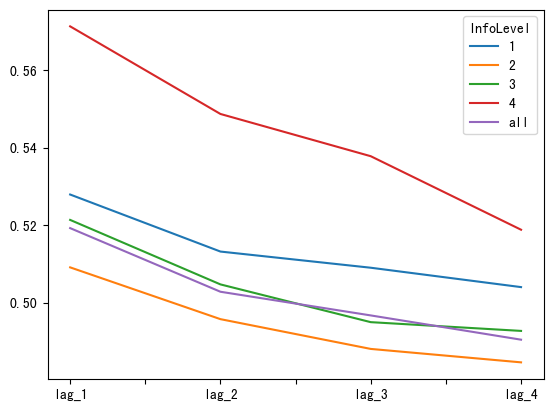

In [47]:
def corr_df(x, y, n):
    res = []
    for i in range(len(x)):
        res.append(np.corrcoef(x.iloc[i], y.iloc[i])[0,1])
    res.extend([np.nan for i in range(n)])
    return res

def corr_one_for_all(x,y,n):
    xx = [i.tolist() for i in x]
    print(xx)
    
res = {
    'InfoLevel':[],
    'lag_1':[],
    'lag_2':[],
    'lag_3':[],
    'lag_4':[]
}

for i in [1,2,3,4,'all']:
    if i=='all':
        policy_of_infolevel = temp
    else:
        policy_of_infolevel = temp.loc[temp['信息级别_InfoLevel']==i]
    policy_of_infolevel = (policy_of_infolevel.copy(deep=True)
                           .sort_values(by='InfoPublDateNP')
                           .assign(corr_next = lambda x: corr_df(x['DocVec'].iloc[:-1], x['DocVec'].shift(-1).iloc[:-1], 1))
                           .assign(corr_next2 = lambda x: corr_df(x['DocVec'].iloc[:-2], x['DocVec'].shift(-2).iloc[:-2], 2))
                           .assign(corr_next3 = lambda x: corr_df(x['DocVec'].iloc[:-3], x['DocVec'].shift(-3).iloc[:-3], 3))
                           .assign(corr_next4 = lambda x: corr_df(x['DocVec'].iloc[:-4], x['DocVec'].shift(-4).iloc[:-4], 4))
                          )
#     display(policy_of_infolevel.head())
    res['InfoLevel'].append(i)
    res['lag_1'].append(np.nanmean(policy_of_infolevel['corr_next']))
    res['lag_2'].append(np.nanmean(policy_of_infolevel['corr_next2']))
    res['lag_3'].append(np.nanmean(policy_of_infolevel['corr_next3']))
    res['lag_4'].append(np.nanmean(policy_of_infolevel['corr_next4']))
    
display(pd.DataFrame(res))
pd.DataFrame(res).set_index('InfoLevel').T.plot()

In [33]:
tem = pd.DataFrame(res)
tem['lag_2'] = ((tem['lag_2']-tem['lag_1'])/tem['lag_1'])*100
tem['lag_3'] = ((tem['lag_3']-tem['lag_1'])/tem['lag_1'])*100
tem['lag_4'] = ((tem['lag_4']-tem['lag_1'])/tem['lag_1'])*100
tem

,InfoLevel,lag_1,lag_2,lag_3,lag_4
0,1,0.527935,-2.786447,-3.576494,-4.523213
1,2,0.509147,-2.623015,-4.131015,-4.811227
2,3,0.521386,-3.190021,-5.057389,-5.490075
3,4,0.571303,-3.955036,-5.861903,-9.180483
4,all,0.519269,-3.160344,-4.335864,-5.540697


,InfoLevel,lag_1,lag_2,lag_3,lag_4
0,1,0.4321,0.4061,0.4005,0.3905
1,2,0.3997,0.3817,0.3734,0.3666
2,3,0.4305,0.4156,0.3986,0.3981
3,4,0.5239,0.5011,0.485,0.4644
4,all,0.4166,0.3949,0.3876,0.3797


<Axes: >

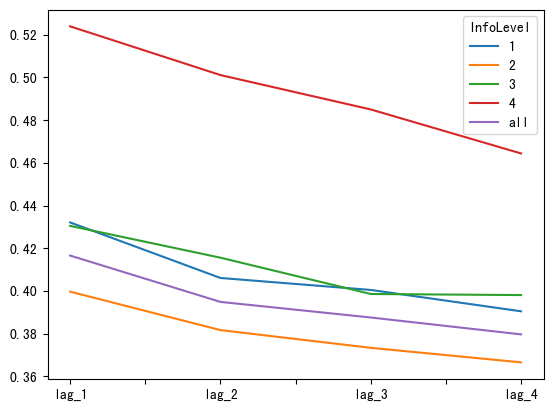

In [34]:
import scipy

def corr_one_for_all(x,y):
    xx = [j for i in x for j in i]
    yy = [j for i in y for j in i]
    corr, pvalue = scipy.stats.pearsonr(xx,yy)
    return "{}".format(np.round(corr, 4), pvalue2stars(pvalue))
    
res = {
    'InfoLevel':[],
    'lag_1':[],
    'lag_2':[],
    'lag_3':[],
    'lag_4':[]
}

for i in [1,2,3,4,'all']:
    if i=='all':
        policy_of_infolevel = temp
    else:
        policy_of_infolevel = temp.loc[temp['信息级别_InfoLevel']==i]
    policy_of_infolevel = (policy_of_infolevel.copy(deep=True)
                           .sort_values(by='InfoPublDateNP')
                           .assign(DocVec_next = lambda x: x['DocVec'].shift(-1))
                           .assign(DocVec_next2 = lambda x: x['DocVec'].shift(-2))
                           .assign(DocVec_next3 = lambda x: x['DocVec'].shift(-3))
                           .assign(DocVec_next4 = lambda x: x['DocVec'].shift(-4))
                           .dropna()
                          )
    res['InfoLevel'].append(i)
    res['lag_1'].append(corr_one_for_all(policy_of_infolevel['DocVec'], policy_of_infolevel['DocVec_next']))
    res['lag_2'].append(corr_one_for_all(policy_of_infolevel['DocVec'], policy_of_infolevel['DocVec_next2']))
    res['lag_3'].append(corr_one_for_all(policy_of_infolevel['DocVec'], policy_of_infolevel['DocVec_next3']))
    res['lag_4'].append(corr_one_for_all(policy_of_infolevel['DocVec'], policy_of_infolevel['DocVec_next4']))
    
display(pd.DataFrame(res))
pd.DataFrame(res).set_index('InfoLevel').T.astype('float').plot()

### 不同级别政策文本的积极词语和消极词语的个数是否相差很多？

In [50]:
Industry_policy.columns

Index(['观测ID()_ID', '事件标志_EventFlg', '信息发布日期_InfoPubDt', '媒体出处代码()_MediaCd',
       '媒体出处_Media', '撰写机构_Writer', '作者_Author', '信息内容_Content',
       '信息对象代码()_ObjCd', '信息地域划分代码()_RegionCd', '涉及机构编码_InvInsCd',
       '涉及机构名称_InvInsNm', '信息级别_InfoLevel', '省市编码_ProvNum', '省市名称_Prov',
       '行业编码_IndNum', '行业板块_IndPla', '行业代码_IndCd', '行业名称_IndNm', '记录时间_RecDt',
       'Unnamed: 20', 'ID', 'InfoPublDate', 'Media', 'MediaCode', 'Writer',
       'Author', 'InfoTitle', 'Content', 'InfoPublDateNP', 'TokenContent',
       'DocVec', 'InfoPublYear', 'InfoPublMon'],
      dtype='object')

In [71]:
negative_words = set(pd.read_excel('/Users/yanyan/Downloads/中文金融情感词典_姜富伟等(2020).xlsx', sheet_name='negative').applymap(lambda x: x.strip())['Negative Word'])
positive_words = set(pd.read_excel('/Users/yanyan/Downloads/中文金融情感词典_姜富伟等(2020).xlsx', sheet_name='positive').applymap(lambda x: x.strip())['Positive Word'])

def count_feeling(token_list, words_set):
    num=0
    for i in token_list:
        if i in words_set: num+=1
    return num

count_feeling_df = (Industry_policy[['信息级别_InfoLevel','TokenContent']]
                    .assign(pos_num = lambda x: x[['TokenContent']].applymap(lambda x: count_feeling(x, positive_words)))
                    .assign(neg_num = lambda x: x[['TokenContent']].applymap(lambda x: count_feeling(x, negative_words)))
                   )

display(count_feeling_df.head())
display(count_feeling_df.groupby('信息级别_InfoLevel')[['pos_num','neg_num']].mean())

,信息级别_InfoLevel,TokenContent,pos_num,neg_num
0,2,"[小费, 阿姨, 小钟, 老师, 近期, 关注, 上市, 公司, 上市公司, 发布, 临时,...",30,8
1,3,"[8, 月, 17, 日, 国家, 药品, 监督, 管理, 管理局, 国家药品监督管理局, ...",43,12
2,2,"[中证网, 讯, 9, 月, 24, 日, 中国, 特钢, 企业, 协会, 发布, 符合, ...",12,6
3,2,"[近日, 农业, 农村, 农村部, 制定, 印发, 十四, 四五, 十四五, 全国, 畜牧,...",49,12
4,3,"[近日, 农业, 农村, 农村部, 印发, 国家, 动物, 疫病, 强制, 免疫, 指导, ...",28,10


,pos_num,neg_num
信息级别_InfoLevel,,
1,31.853775,18.426311
2,38.865112,13.658126
3,41.121262,13.673588
4,29.576728,10.740304
5,23.250000,10.500000


In [72]:
count_feeling_df.groupby('信息级别_InfoLevel').count()

,TokenContent,pos_num,neg_num
信息级别_InfoLevel,,,
1,6066,6066,6066
2,13426,13426,13426
3,2408,2408,2408
4,593,593,593
5,4,4,4


AttributeError: module 'pandas' has no attribute 'isin'